In [ ]:
# download nltk stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Install a particular version of `google-cloud-storage` because (oddly enough)
# the  version on Colab and GCP is old. A dependency error below is okay.
!pip install -q google-cloud-storage==1.43.0

In [ ]:
# authenticate below for Google Storage access as needed
from google.colab import auth
auth.authenticate_user()

In [ ]:
!pip install pyngrok

In [ ]:
# TODO: sign up for an ngrok account
# then put your ngrok token below and execute
from pyngrok import ngrok
ngrok.set_auth_token("YOUR_NGROK_AUTHTOKEN_HERE")

# Run the app

In [ ]:
# you need to upload your implementation of search_app.py
import search_frontend as se

In [ ]:
# uncomment the code below and execute to reload the module when you make
# changes to search_frontend.py (after you upload again).
# import importlib
# importlib.reload(se)

In [ ]:
public_url = ngrok.connect("5000", bind_tls=False).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:5000\"")
# Update any base URLs to use the public ngrok URL
se.app.config["BASE_URL"] = public_url
se.app.run()

 * ngrok tunnel "http://d116-34-80-115-88.ngrok-free.app" -> "http://127.0.0.1:5000"
 * Serving Flask app 'search_frontend'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [19/Feb/2024 00:52:56] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [19/Feb/2024 00:52:57] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [19/Feb/2024 00:53:03] "GET /search HTTP/1.1" 200 -


# Testing your app

Once your app is running you can query it. You can simply do that by navigating to the URL that ngrok gave you above or through code in a different python session. For example, once the frontend app is running, you can navigate to:
http://YOUR_SERVER_DOMAIN/search?query=hello+world where YOUR_SERVER_DOMAIN is something like XXXX-XX-XX-XX-XX.ngrok.io, which is printed above in Colab or that is your external IP on GCP.

The code below shows how to issue a query from python. This is also how our testing code will issue queries to your search engine, so make sure to test your search engine this way after you deploy it to GCP and before submission. Command line instructions for deploying your search engine to GCP are available at `run_frontend_in_gcp.sh`. Note that we will not only issue training queries to your search engine, but also test queries, i.e. queries that you've never seen before.

In [13]:
import json

with open('queries_train.json', 'rt') as f:
  queries = json.load(f)

In [14]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [15]:
def precision_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(predicted_list) == 0:
        return 0.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(predicted_list), 3)
def recall_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(true_set) < 1:
        return 1.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(true_set), 3)
def f1_at_k(true_list, predicted_list, k):
    p = precision_at_k(true_list, predicted_list, k)
    r = recall_at_k(true_list, predicted_list, k)
    if p == 0.0 or r == 0.0:
        return 0.0
    return round(2.0 / (1.0/p + 1.0/r), 3)
def results_quality(true_list, predicted_list):
    p5 = precision_at_k(true_list, predicted_list, 5)
    f1_30 = f1_at_k(true_list, predicted_list, 30)
    if p5 == 0.0 or f1_30 == 0.0:
        return 0.0
    return round(2.0 / (1.0/p5 + 1.0/f1_30), 3)

assert precision_at_k(range(10), [1,2,3] , 2) == 1.0
assert recall_at_k(   range(10), [10,5,3], 2) == 0.1
assert precision_at_k(range(10), []      , 2) == 0.0
assert precision_at_k([],        [1,2,3],  5) == 0.0
assert recall_at_k(   [],        [10,5,3], 2) == 1.0
assert recall_at_k(   range(10), [],       2) == 0.0
assert f1_at_k(       [],        [1,2,3],  5) == 0.0
assert f1_at_k(       range(10), [],       2) == 0.0
assert f1_at_k(       range(10), [0,1,2],  2) == 0.333
assert f1_at_k(       range(50), range(5), 30) == 0.182
assert f1_at_k(       range(50), range(10), 30) == 0.333
assert f1_at_k(       range(50), range(30), 30) == 0.75
assert results_quality(range(50), range(5))  == 0.308
assert results_quality(range(50), range(10)) == 0.5
assert results_quality(range(50), range(30)) == 0.857
assert results_quality(range(50), [-1]*5 + list(range(5,30))) == 0.0


In [22]:
#####do not run!######
all_models_time = []
all_models_preformence=[]
all_models_p10 = []


In [37]:
import requests
from time import time
import statistics

# url = 'http://35.232.59.3:8080'
# place the domain you got from ngrok or GCP IP below.
url = 'http://35.193.224.158:8080'

performence =[]
time_array=[]
qs_res = []

for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search', {'query': q}, timeout=500)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      rq = results_quality(true_wids, pred_wids)
      p10 = precision_at_k(true_wids, pred_wids,10)
      print(q)
      print(duration)
  except:
    pass
  performence.append(rq)
  time_array.append(duration)
  qs_res.append((q, duration, rq))

all_models_time.append(statistics.mean(time_array))
all_models_preformence.append(statistics.mean(performence))

genetics
16.70231580734253
Who is considered the "Father of the United States"?
18.225884199142456
economic
17.247354745864868
When was the United Nations founded?
18.214583158493042
video gaming
17.668691396713257
3D printing technology
17.494703769683838
Who is the author of "1984"?
18.216100931167603
bioinformatics
17.802221298217773
Who is known for proposing the heliocentric model of the solar system?
18.787864923477173
Describe the process of water erosion.
18.604865789413452
When was the Berlin Wall constructed?
18.217015504837036
What is the meaning of the term "Habeas Corpus"?
18.597058296203613
telecommunications
17.167735815048218
internet
17.17560601234436
What are the characteristics of a chemical element?
17.413942098617554
Describe the structure of a plant cell.
19.09648871421814
Who painted "Starry Night"?
18.236865520477295
computer
17.67898416519165
What is the structure of the Earth's layers?
18.20530891418457
When did World War II end?
16.815834045410156
When was th

In [38]:
#anchor
qs_res

[('genetics', 16.70231580734253, 0.179),
 ('Who is considered the "Father of the United States"?',
  18.225884199142456,
  0.0),
 ('economic', 17.247354745864868, 0.16),
 ('When was the United Nations founded?', 18.214583158493042, 0.0),
 ('video gaming', 17.668691396713257, 0.0),
 ('3D printing technology', 17.494703769683838, 0.095),
 ('Who is the author of "1984"?', 18.216100931167603, 0.0),
 ('bioinformatics', 17.802221298217773, 0.486),
 ('Who is known for proposing the heliocentric model of the solar system?',
  18.787864923477173,
  0.0),
 ('Describe the process of water erosion.', 18.604865789413452, 0.0),
 ('When was the Berlin Wall constructed?', 18.217015504837036, 0.0),
 ('What is the meaning of the term "Habeas Corpus"?',
  18.597058296203613,
  0.081),
 ('telecommunications', 17.167735815048218, 0.0),
 ('internet', 17.17560601234436, 0.164),
 ('What are the characteristics of a chemical element?',
  17.413942098617554,
  0.0),
 ('Describe the structure of a plant cell.', 

In [39]:
#anchor
all_models_time

[19.48090382417043, 20.831198517481486, 19.789182933171592, 17.800860651334126]

In [44]:
all_models_preformence

[0.11176666666666667,
 0.11133333333333334,
 0.11133333333333334,
 0.11156666666666668]

In [45]:
models = ['selected model','selected model with anchor index','selected model, different weight for indexes','seleced model, pr without log']

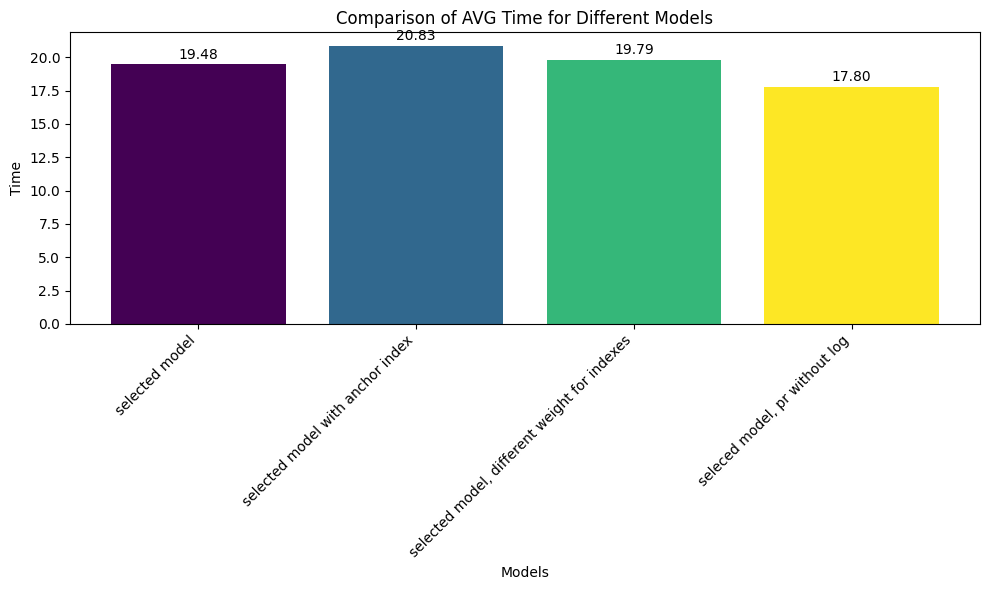

In [49]:
import matplotlib.pyplot as plt
import numpy as np


# Create a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(all_models_time)))

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, all_models_time, color=colors)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Time')
plt.title('Comparison of AVG Time for Different Models')
plt.xticks(rotation=45, ha='right')

# Emphasize differences between bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height * 1.01, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()

# Show plot
plt.show()

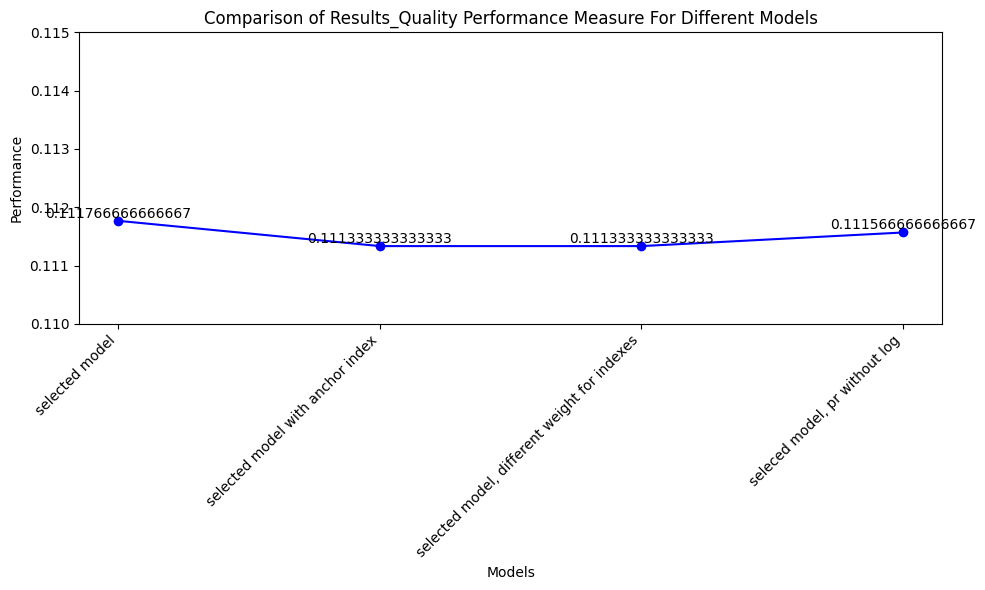

In [66]:

# Create line plot
plt.figure(figsize=(10, 6))
plt.plot(models, all_models_preformence, marker='o', color='blue', linestyle='-')

# Add labels of y-values
for i, performance in enumerate(all_models_preformence):
    plt.text(models[i], performance, f'{performance:.15f}', ha='center', va='bottom')

# Set y-axis limit
plt.ylim(0.1100, 0.1150)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Performance')
plt.title('Comparison of Results_Quality Performance Measure For Different Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show plot
plt.show()